# Importing libraries

In [1]:
import pandas as pd
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Concatenate
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input
from keras.models import Model

In [4]:
import seaborn as sns

In [5]:
!pip install livelossplot

In [6]:
from livelossplot import PlotLossesKeras

#Data mining, cleaning and transformation

In [ ]:
def read_and_filter_fits(file_path):
    df = Table.read(file_path).to_pandas()
    return df[df['Flags'] == 0]

df_h = read_and_filter_fits('/content/table-4LAC-DR3-h.fits') # high altitude data
df_l = read_and_filter_fits('/content/table-4LAC-DR3-l.fits') # Low altitude data

classification_df = pd.concat([df_h, df_l], ignore_index=True) # Concatenate dataframes and filter based on CLASS
classification_df['CLASS'] = classification_df['CLASS'].str.decode('utf-8').str.upper()
classification_df = classification_df[classification_df['CLASS'].isin(['BLL', 'FSRQ', 'BCU'])]

selected_columns = ['PL_Index', 'nu_syn', 'LP_Index', 'Pivot_Energy', 'Frac_Variability', 'Variability_Index', 'nuFnu_syn', 'CLASS']
classification_df = classification_df[selected_columns]

classification_df.head()

In [ ]:
classification_df.to_csv('Dataset.csv', index=False)

In [24]:
classification_df = pd.read_csv('/content/Dataset.csv')

In [ ]:
classification_df.shape

(3120, 8)

In [ ]:
classification_df

,PL_Index,nu_syn,LP_Index,Pivot_Energy,Frac_Variability,Variability_Index,nuFnu_syn,CLASS
0,2.271696,1.000000e+14,2.254081,2420.57520,0.675882,25.313953,3.716456e-13,BCU
1,2.116692,9.120108e+13,2.078927,1721.60390,0.406565,46.780693,1.936770e-12,BLL
2,1.939160,3.609939e+12,1.661223,4307.08250,0.000000,9.272764,2.473256e-13,BLL
3,2.654060,1.584893e+14,2.514159,329.77374,0.996138,1910.935800,1.152471e-12,FSRQ
4,1.876663,1.659588e+13,1.716620,4429.93400,0.902851,24.557972,9.716011e-13,BCU
...,...,...,...,...,...,...,...,...
3115,2.071567,3.311315e+13,2.042366,5897.85400,0.328630,14.602383,1.006315e-12,BCU
3116,2.226648,0.000000e+00,1.962429,3114.22630,1.071415,34.235767,0.000000e+00,BCU
3117,2.045913,0.000000e+00,2.019132,5066.52540,0.337927,22.359163,0.000000e+00,BCU
3118,1.810977,1.566751e+16,1.736923,1910.88570,0.201833,58.688427,1.279994e-11,BLL


In [ ]:
classification_df.describe()

,PL_Index,nu_syn,LP_Index,Pivot_Energy,Frac_Variability,Variability_Index,nuFnu_syn
count,3120.000000,3.120000e+03,3120.000000,3120.000000,3120.000000,3120.000000,3.120000e+03
mean,2.189187,2.193630e+16,2.098539,2632.568851,0.413246,252.752911,2.162825e-12
std,0.287124,3.956905e+17,0.344169,2671.623150,0.383216,2327.976117,7.101226e-12
min,1.418864,0.000000e+00,-0.048980,295.327550,0.000000,1.600064,0.000000e+00
25%,1.971043,1.584893e+12,1.868027,1007.767350,0.053641,12.758991,1.900654e-13
50%,2.181250,1.288250e+13,2.097951,1793.103250,0.357368,21.004428,7.363399e-13
75%,2.400465,2.490321e+14,2.333431,3277.535700,0.613080,56.243972,1.912875e-12
max,3.075706,1.757927e+19,3.204185,30936.535000,2.910003,84340.760000,2.198239e-10


In [25]:
feature_columns = ['PL_Index',
 'nu_syn',
 'LP_Index',
 'Pivot_Energy',
 'Frac_Variability',
 'Variability_Index',
 'nuFnu_syn']
target = 'CLASS'

In [26]:
#we will be using log on the columns having high varience.
for column in feature_columns:
    if(column in ["Frac_Variability","LP_Index", "PL_Index"]):
        continue
    else:
        if column == 'nuFnu_syn':
            classification_df[column] = np.log(classification_df[column]+ 1e-12) #adding a constant because to obey the domain of the log. as min value of nuFun_syn is zero
        elif column == 'nu_syn':
            classification_df[column] = np.log(classification_df[column] + 1e12) #adding a constant because to obey the domain of the log. as min value of nu_syn is zero
        else:
            classification_df[column] = np.log(classification_df[column])


#Visualizing

In [ ]:
class_counts = classification_df['CLASS'].value_counts()
class_counts

CLASS
BLL     1335
BCU     1115
FSRQ     670
Name: count, dtype: int64

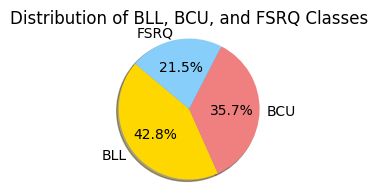

In [ ]:
#creating the pie chart
labels = class_counts.index
sizes = class_counts.values
colors = ['gold', 'lightcoral', 'lightskyblue']

plt.figure(figsize=(2, 2))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)
plt.axis('equal')

plt.title('Distribution of BLL, BCU, and FSRQ Classes')
plt.show()

#Splitting dataset into training, validating and testing sets and scaling them

**Here is what we will be doing**


1.  At first we will be taking out all the BCUs from the dataset. As we will be deploying our best performing model on these BCUs to perhaps come up with a suitable prediction.
2.  After filtering out the dataset with only WELL classified blazers remaining, we will split this into three parts: Train, val and test in the ratio 80:10:10.
3. We will also be standerdizing the sets so that our algorithm can converge better.






In [27]:
bcu_samples = classification_df[classification_df['CLASS'].isin(['BCU'])] #seggregating the dataset in corresponding with BCU
classification_df = classification_df[classification_df['CLASS'] != 'BCU']

print("The number of unclassified samples, aka BCUs are:", bcu_samples.shape)
print("The number of classified samples are: ", classification_df.shape)

The number of unclassified samples, aka BCUs are: (1115, 8)
The number of classified samples are:  (2005, 8)


In [29]:
class_mapping = {'BLL': 0, 'FSRQ': 1}
classification_df.loc[:, 'CLASS'] = classification_df['CLASS'].map(class_mapping)

In [12]:
labels = classification_df['CLASS']
features = classification_df.drop([target], axis=1)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.20, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=42)

In [14]:
print("X_train.shape =", X_train.shape, " y_tain.shape =", y_train.shape)
print("X_val.shape = ",X_val.shape," y_val.shape =", y_val.shape)
print("X_test.shape = ",X_test.shape," y_test.shape =", y_test.shape)

X_train.shape = (1604, 7)  y_tain.shape = (1604,)
X_val.shape =  (200, 7)  y_val.shape = (200,)
X_test.shape =  (201, 7)  y_test.shape = (201,)


In [33]:
transformer = make_column_transformer(
    (StandardScaler(),
        feature_columns)
)

In [34]:
transformer.fit(X_train) #learning the statistics like mean and varience.
X_train = transformer.transform(X_train) #indiviually standardizing all the sets with the statistics learnt in fom X_train, it is done so that consistency is maintained throughout all sets.
X_test = transformer.transform(X_test)
X_val = transformer.transform(X_val)
bcu_samples = transformer.transform(bcu_samples) #pls note that the class column will be droped.

In [36]:
# Convert labels datasets to floats
y_train = y_train.astype(float)
y_val = y_val.astype(float)
y_test= y_test.astype(float)

In [ ]:
cw = compute_class_weight(class_weight='balanced', classes = np.unique(y_train), y = y_train)
cw = {0:cw[0], 1:cw[1]}
cw

{0: 0.761633428300095, 1: 1.455535390199637}

# Model_1
*Initializing bias in the output layer*

*Initializing the bias in the output layer as log of ratio of Bll and Fsrq. The exact value wasn't mentioned in the paper, however it is evident in the open source code provided in the paper.*

In [ ]:
bll, fsrq = np.bincount(y_train) #this counts the number of bll and fsrq in the training set. and sets their ratio as the initial output bias.
log_ratio = np.log(fsrq / bll)

print(f"log_ratio: {log_ratio}")

log_ratio: -0.6476637029810611


In [ ]:
output_bias = Constant(log_ratio)
NN_with_initialization= Sequential([
    Dense(42, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(1, activation='sigmoid', bias_initializer=output_bias)
])
NN_with_initialization.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 42)                336       
                                                                 
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 43        
                                                                 
Total params: 379 (1.48 KB)
Trainable params: 379 (1.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
NN_with_initialization.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=300)

In [ ]:
checkpoint = ModelCheckpoint(
    filepath='/content/_epoch_{epoch:02d}.h5',
    monitor='val_loss',
    save_best_only=False,
    save_freq='epoch',
    verbose=1,
    mode = 'min' ,
    save_weights_only=False,

)

In [ ]:
history = NN_with_initialization.fit(
        X_train,
        y_train,
        epochs=1500,
        batch_size=2048,
        verbose=1,
        validation_data=(X_val, y_val),
        callbacks = [checkpoint, early_stopping],
    )

Epoch 1/1500
1/1 [==============================] - ETA: 0s - loss: 0.6768 - accuracy: 0.6590
Epoch 1: saving model to /content/_epoch_01.h5
1/1 [==============================] - 1s 1s/step - loss: 0.6768 - accuracy: 0.6590 - val_loss: 0.5943 - val_accuracy: 0.7000
Epoch 2/1500
1/1 [==============================] - ETA: 0s - loss: 0.6807 - accuracy: 0.6465
Epoch 2: saving model to /content/_epoch_02.h5
1/1 [==============================] - 0s 60ms/step - loss: 0.6807 - accuracy: 0.6465 - val_loss: 0.5860 - val_accuracy: 0.7000
Epoch 3/1500
1/1 [==============================] - ETA: 0s - loss: 0.6858 - accuracy: 0.6509
Epoch 3: saving model to /content/_epoch_03.h5
1/1 [==============================] - 0s 81ms/step - loss: 0.6858 - accuracy: 0.6509 - val_loss: 0.5778 - val_accuracy: 0.7000
Epoch 4/1500
1/1 [==============================] - ETA: 0s - loss: 0.6409 - accuracy: 0.6633

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 4: saving model to /content/_epoch_04.h5
1/1 [==============================] - 0s 87ms/step - loss: 0.6409 - accuracy: 0.6633 - val_loss: 0.5698 - val_accuracy: 0.7000
Epoch 5/1500
1/1 [==============================] - ETA: 0s - loss: 0.6322 - accuracy: 0.6714
Epoch 5: saving model to /content/_epoch_05.h5
1/1 [==============================] - 0s 58ms/step - loss: 0.6322 - accuracy: 0.6714 - val_loss: 0.5620 - val_accuracy: 0.7000
Epoch 6/1500
1/1 [==============================] - ETA: 0s - loss: 0.6314 - accuracy: 0.6727
Epoch 6: saving model to /content/_epoch_06.h5
1/1 [==============================] - 0s 65ms/step - loss: 0.6314 - accuracy: 0.6727 - val_loss: 0.5543 - val_accuracy: 0.7050
Epoch 7/1500
1/1 [==============================] - ETA: 0s - loss: 0.6228 - accuracy: 0.6877
Epoch 7: saving model to /content/_epoch_07.h5
1/1 [==============================] - 0s 77ms/step - loss: 0.6228 - accuracy: 0.6877 - val_loss: 0.5468 - val_accuracy: 0.7050
Epoch 8/1500
1/1 

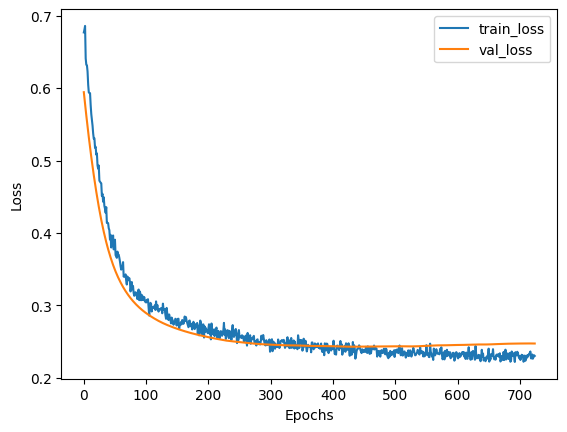

In [ ]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model_epoch_40 = tf.keras.models.load_model('/content/_epoch_40.h5')
model_epoch_41 = tf.keras.models.load_model('/content/_epoch_41.h5')

pred_probs_40 = model_epoch_40.predict(X_test) # Probabilities for class 1 from model at 40th epoch
pred_probs_41 = model_epoch_41.predict(X_test)  # Probabilities for class 1 from model at 41st epoch

# Step 3: Combine Predictions with the specified ratio
combined_pred_probs = (0.1 * pred_probs_40) + (0.9 * pred_probs_41)

# Step 4: Compute Final Predictions
final_predictions = (combined_pred_probs > 0.5).astype(int)  # Threshold at 0.5 for binary classification

# If you need the predicted probabilities, use combined_pred_probs
# If you need the class labels, use fin
print("Final predictions with soft voting:", final_predictions)

7/7 [==============================] - 0s 3ms/step
Final predictions with soft voting: [[1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0

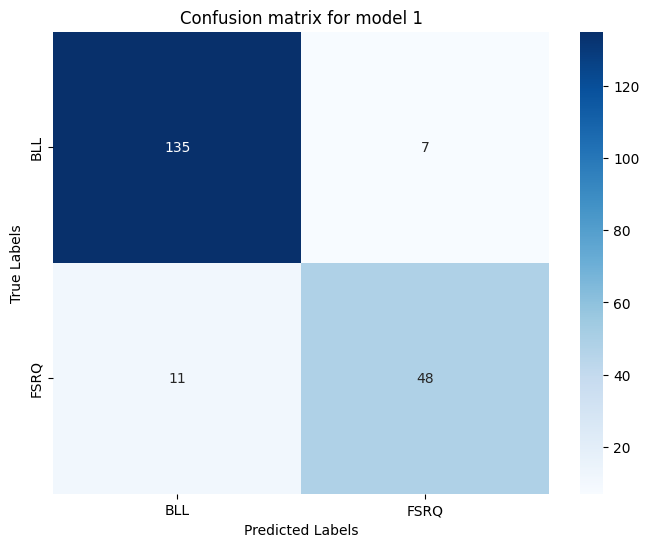

In [ ]:
conf_matrix = confusion_matrix(y_test, final_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['BLL', 'FSRQ'], yticklabels=['BLL', 'FSRQ'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion matrix for model 1')
plt.show()


# Model 2
*Using greedy approach to first train the model without hidden layers and then the hidden layer wihtout the input, and then using these weights as the initial weights for the whole network*

In [ ]:
model_2 = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                512       
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 577 (2.25 KB)
Trainable params: 577 (2.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model_2.fit(X_train, y_train, epochs=300, batch_size=2048, verbose=1, validation_data=(X_val, y_val))

Epoch 1/300
1/1 [==============================] - 2s 2s/step - loss: 0.6276 - accuracy: 0.6627 - val_loss: 0.5881 - val_accuracy: 0.7400
Epoch 2/300
1/1 [==============================] - 0s 84ms/step - loss: 0.6265 - accuracy: 0.6584 - val_loss: 0.5787 - val_accuracy: 0.7800
Epoch 3/300
1/1 [==============================] - 0s 85ms/step - loss: 0.6108 - accuracy: 0.6933 - val_loss: 0.5695 - val_accuracy: 0.7850
Epoch 4/300
1/1 [==============================] - 0s 82ms/step - loss: 0.5992 - accuracy: 0.7001 - val_loss: 0.5605 - val_accuracy: 0.8100
Epoch 5/300
1/1 [==============================] - 0s 81ms/step - loss: 0.5855 - accuracy: 0.7195 - val_loss: 0.5517 - val_accuracy: 0.8250
Epoch 6/300
1/1 [==============================] - 0s 82ms/step - loss: 0.5842 - accuracy: 0.7251 - val_loss: 0.5431 - val_accuracy: 0.8650
Epoch 7/300
1/1 [==============================] - 0s 67ms/step - loss: 0.5738 - accuracy: 0.7251 - val_loss: 0.5347 - val_accuracy: 0.8650
Epoch 8/300
1/1 [=====

In [ ]:
output_layer = model_2.layers[-1]
model_2.pop()
for layer in model_2.layers:
    layer.trainable = False
model_2.add(tf.keras.layers.Dense(32, activation='relu', name='Hidden-Layer-2'))
model_2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                512       
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 Hidden-Layer-2 (Dense)      (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2625 (10.25 KB)
Trainable params: 2113 (8.25 KB)
Non-trainable params: 512 (2.00 KB)
_________________________________________________________________


In [ ]:
model_2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model_2.fit(X_train, y_train, epochs=300, batch_size=2048, verbose=1, validation_data=(X_val, y_val))

Epoch 1/300
1/1 [==============================] - 4s 4s/step - loss: 0.8505 - accuracy: 0.3392 - val_loss: 0.8220 - val_accuracy: 0.3000
Epoch 2/300
1/1 [==============================] - 0s 46ms/step - loss: 0.8224 - accuracy: 0.3890 - val_loss: 0.7953 - val_accuracy: 0.3600
Epoch 3/300
1/1 [==============================] - 0s 50ms/step - loss: 0.8069 - accuracy: 0.3971 - val_loss: 0.7694 - val_accuracy: 0.3850
Epoch 4/300
1/1 [==============================] - 0s 63ms/step - loss: 0.7791 - accuracy: 0.4383 - val_loss: 0.7443 - val_accuracy: 0.4400
Epoch 5/300
1/1 [==============================] - 0s 67ms/step - loss: 0.7569 - accuracy: 0.4769 - val_loss: 0.7200 - val_accuracy: 0.5050
Epoch 6/300
1/1 [==============================] - 0s 63ms/step - loss: 0.7150 - accuracy: 0.5430 - val_loss: 0.6966 - val_accuracy: 0.5500
Epoch 7/300
1/1 [==============================] - 0s 78ms/step - loss: 0.7134 - accuracy: 0.5455 - val_loss: 0.6740 - val_accuracy: 0.5950
Epoch 8/300
1/1 [=====

In [ ]:
output_layer = model_2.layers[-1]
model_2.pop()
for layer in model_2.layers:
    layer.trainable = False

model_2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                512       
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 Hidden-Layer-2 (Dense)      (None, 32)                2080      
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2625 (10.25 KB)
Trainable params: 33 (132.00 Byte)
Non-trainable params: 2592 (10.12 KB)
_________________________________________________________________


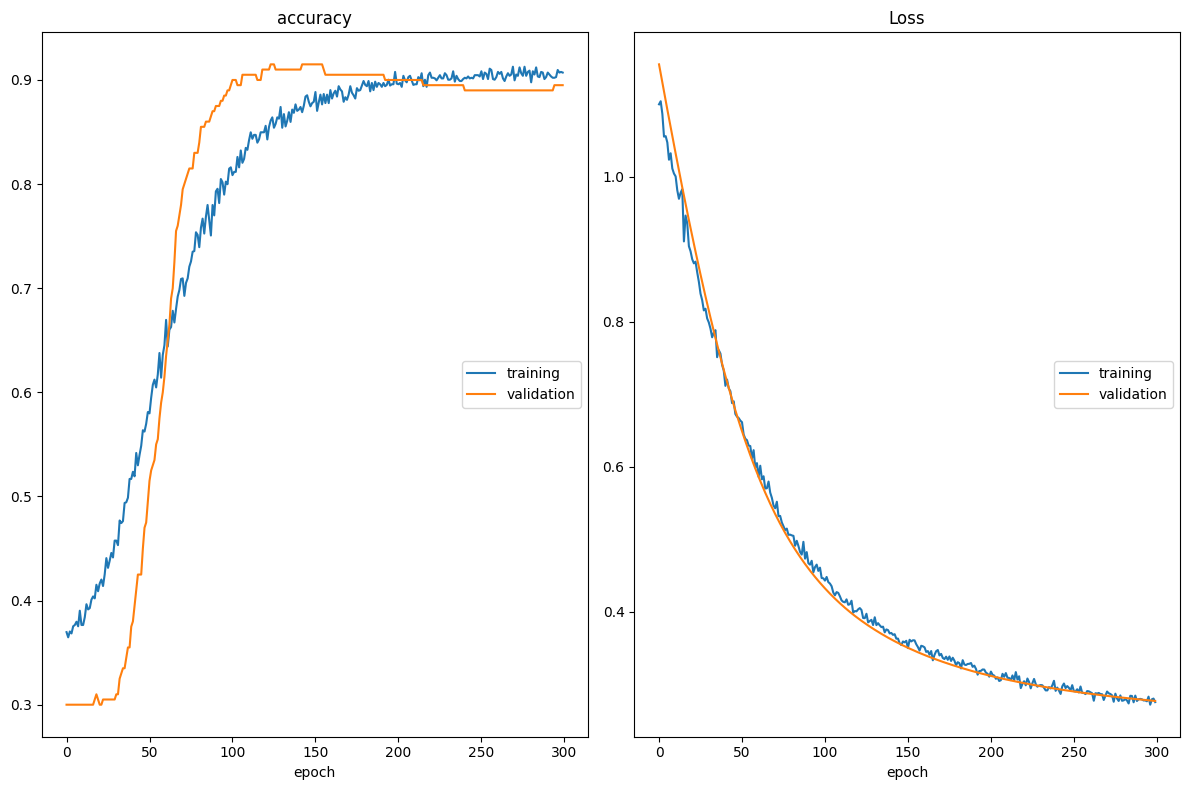

accuracy
	training         	 (min:    0.365, max:    0.913, cur:    0.907)
	validation       	 (min:    0.300, max:    0.915, cur:    0.895)
Loss
	training         	 (min:    0.272, max:    1.104, cur:    0.275)
	validation       	 (min:    0.277, max:    1.155, cur:    0.277)

Epoch 300: saving model to /content/sample_data/_epoch_300.h5
1/1 [==============================] - 1s 806ms/step - loss: 0.2752 - accuracy: 0.9071 - val_loss: 0.2767 - val_accuracy: 0.8950


In [ ]:
model_2.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])
checkpoint = ModelCheckpoint(
    filepath='/content/sample_data/_epoch_{epoch:02d}.h5',
    monitor='val_loss',
    save_best_only=False,
    save_freq='epoch',
    verbose=1,
    mode = 'min' ,
    save_weights_only=False,

)
model_2.fit(
        X_train,
        y_train,
        epochs=300,
        batch_size=2048,
        verbose=1,
        validation_data=(X_val, y_val),
        callbacks = [PlotLossesKeras(), checkpoint]
    )

In [ ]:
predictions = model_2.predict(X_test)
final_predictions = (predictions > 0.5).astype(int)


7/7 [==============================] - 0s 4ms/step


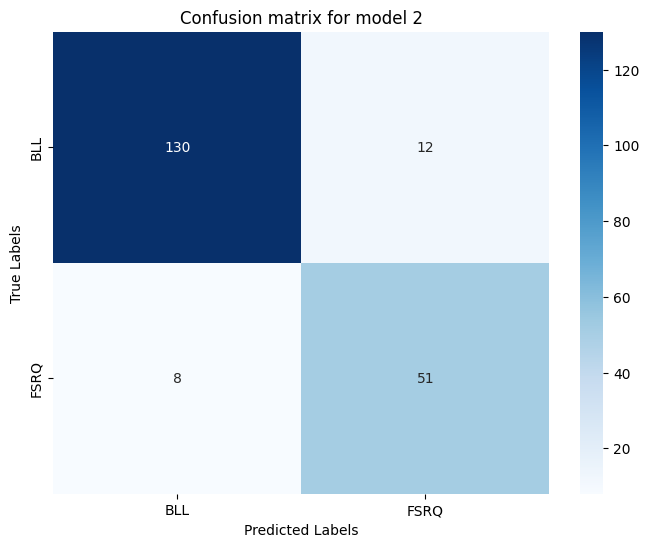

In [ ]:
conf_matrix = confusion_matrix(y_test, final_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['BLL', 'FSRQ'], yticklabels=['BLL', 'FSRQ'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion matrix for model 2')
plt.show()

# Model 3
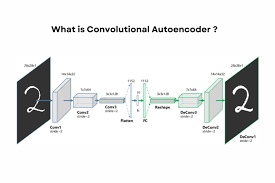

*In this model we will be using an autoencoder model, this model basically takes input and in the output tries to predict the input. This makes the nueral network learn the data distributions, and the basic essaence of the data. It learns to predict the important things in the data*

We will be adding in layers and use the same greedy approach as in model 2, ie train just one layer and then freeze it and train the other.
**once we have desired layers of the encoder, we will pass the compressed layer to our output sigmoid layer**

In [ ]:
model_3 = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(X_train.shape[1], activation='linear')
])
model_3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 64)                512       
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 7)                 455       
                                                                 
Total params: 967 (3.78 KB)
Trainable params: 967 (3.78 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_3.compile(optimizer='adam', loss='mse',  metrics=['mean_squared_error']) #we are using mean squared error between output and input because it is a numerical dataset
model_3.fit(X_train, X_train, epochs=500, batch_size=2048, verbose=1, validation_data=(X_val, X_val))

Epoch 1/500
1/1 [==============================] - 1s 1s/step - loss: 1.5151 - mean_squared_error: 1.5151 - val_loss: 1.3696 - val_mean_squared_error: 1.3696
Epoch 2/500
1/1 [==============================] - 0s 57ms/step - loss: 1.4701 - mean_squared_error: 1.4701 - val_loss: 1.3353 - val_mean_squared_error: 1.3353
Epoch 3/500
1/1 [==============================] - 0s 62ms/step - loss: 1.4571 - mean_squared_error: 1.4571 - val_loss: 1.3018 - val_mean_squared_error: 1.3018
Epoch 4/500
1/1 [==============================] - 0s 56ms/step - loss: 1.4102 - mean_squared_error: 1.4102 - val_loss: 1.2690 - val_mean_squared_error: 1.2690
Epoch 5/500
1/1 [==============================] - 0s 40ms/step - loss: 1.3759 - mean_squared_error: 1.3759 - val_loss: 1.2368 - val_mean_squared_error: 1.2368
Epoch 6/500
1/1 [==============================] - 0s 41ms/step - loss: 1.3412 - mean_squared_error: 1.3412 - val_loss: 1.2054 - val_mean_squared_error: 1.2054
Epoch 7/500
1/1 [=========================

In [ ]:
output_layer = model_3.layers[-1]
model_3.pop()
for layer in model_3.layers:
    layer.trainable = False
model_3.add(tf.keras.layers.Dense(32, activation='relu', name='Hidden-Layer-2'))
model_3.add(tf.keras.layers.Dense(X_train.shape[1], activation='linear'))
model_3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 64)                512       
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 Hidden-Layer-2 (Dense)      (None, 32)                2080      
                                                                 
 dense_19 (Dense)            (None, 7)                 231       
                                                                 
Total params: 2823 (11.03 KB)
Trainable params: 2311 (9.03 KB)
Non-trainable params: 512 (2.00 KB)
_________________________________________________________________


In [ ]:
model_3.compile(optimizer='adam', loss='mse',  metrics=['mean_squared_error']) #we are using mean squared error between output and input because it is a numerical dataset
model_3.fit(X_train, X_train, epochs=500, batch_size=2048, verbose=1, validation_data=(X_val, X_val))

Epoch 1/500
1/1 [==============================] - 1s 1s/step - loss: 1.0960 - mean_squared_error: 1.0960 - val_loss: 1.0385 - val_mean_squared_error: 1.0385
Epoch 2/500
1/1 [==============================] - 0s 40ms/step - loss: 1.0670 - mean_squared_error: 1.0670 - val_loss: 1.0214 - val_mean_squared_error: 1.0214
Epoch 3/500
1/1 [==============================] - 0s 66ms/step - loss: 1.0620 - mean_squared_error: 1.0620 - val_loss: 1.0047 - val_mean_squared_error: 1.0047
Epoch 4/500
1/1 [==============================] - 0s 48ms/step - loss: 1.0383 - mean_squared_error: 1.0383 - val_loss: 0.9882 - val_mean_squared_error: 0.9882
Epoch 5/500
1/1 [==============================] - 0s 58ms/step - loss: 1.0161 - mean_squared_error: 1.0161 - val_loss: 0.9718 - val_mean_squared_error: 0.9718
Epoch 6/500
1/1 [==============================] - 0s 58ms/step - loss: 0.9924 - mean_squared_error: 0.9924 - val_loss: 0.9556 - val_mean_squared_error: 0.9556
Epoch 7/500
1/1 [=========================

In [ ]:
output_layer = model_3.layers[-1]
model_3.pop()
for layer in model_3.layers:
    layer.trainable = False
model_3.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model_3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 64)                512       
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 Hidden-Layer-2 (Dense)      (None, 32)                2080      
                                                                 
 dense_20 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2625 (10.25 KB)
Trainable params: 33 (132.00 Byte)
Non-trainable params: 2592 (10.12 KB)
_________________________________________________________________


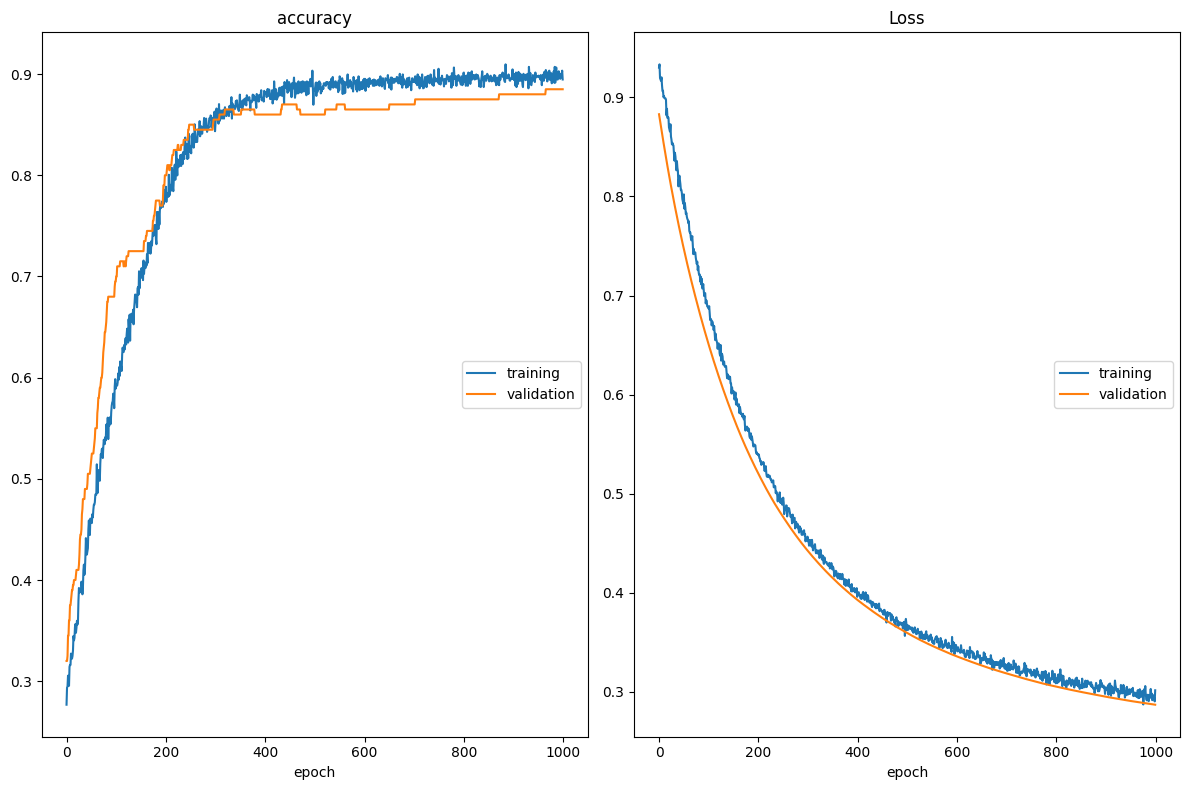

accuracy
	training         	 (min:    0.277, max:    0.910, cur:    0.895)
	validation       	 (min:    0.320, max:    0.885, cur:    0.885)
Loss
	training         	 (min:    0.287, max:    0.933, cur:    0.302)
	validation       	 (min:    0.287, max:    0.883, cur:    0.287)

Epoch 1000: saving model to /kaggle/_epoch_1000.h5
1/1 [==============================] - 1s 787ms/step - loss: 0.3016 - accuracy: 0.8946 - val_loss: 0.2870 - val_accuracy: 0.8850


In [ ]:
model_3.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])
checkpoint = ModelCheckpoint(
    filepath='/kaggle/_epoch_{epoch:02d}.h5',
    monitor='val_loss',
    save_best_only=False,
    save_freq='epoch',
    verbose=1,
    mode = 'min' ,
    save_weights_only=False,
)
model_3.fit(
        X_train,
        y_train,
        epochs=1000,
        batch_size=2048,
        verbose=1,
        validation_data=(X_val, y_val),
        callbacks = [PlotLossesKeras(), checkpoint]
    )

In [ ]:
predictions = model_3.predict(X_test)
final_predictions = (predictions > 0.5).astype(int)

7/7 [==============================] - 0s 3ms/step


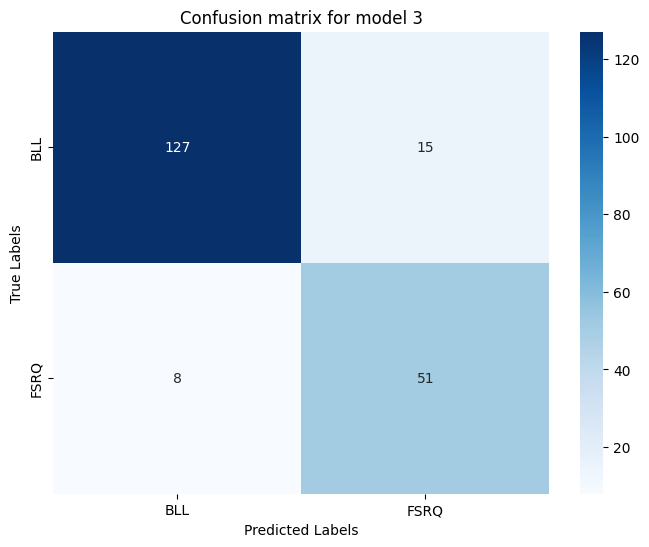

In [ ]:
conf_matrix = confusion_matrix(y_test, final_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['BLL', 'FSRQ'], yticklabels=['BLL', 'FSRQ'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion matrix for model 3')
plt.show()

# Model 4

*This is a simple autoencoder model which is trianed without any greedy approach. After training the autoencoder, the bottleneck layer will be then fed to the output layer to make a prediction.*

In [ ]:
input_layer = Input(shape=(7,))
encoder = Dense(128, activation='relu')(input_layer)
encoder = Dense(64, activation='relu')(encoder)
encoded = Dense(32, activation='relu')(encoder)


decoder = Dense(64, activation='relu')(encoded)
decoder = Dense(128, activation='relu')(decoder)
decoded = Dense(7, activation='linear')(decoder)

In [ ]:
encoder_model = Model(inputs=input_layer, outputs=encoded)
self_supervised_model = Model(inputs=input_layer, outputs=decoded)

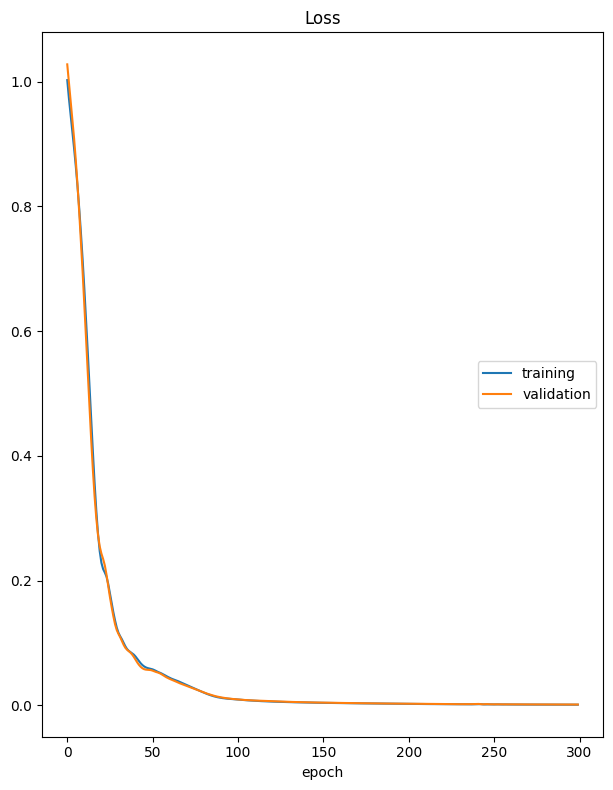

Loss
	training         	 (min:    0.001, max:    1.002, cur:    0.001)
	validation       	 (min:    0.001, max:    1.028, cur:    0.001)
1/1 [==============================] - 0s 357ms/step - loss: 0.0011 - val_loss: 0.0014


In [ ]:
self_supervised_model.compile(optimizer='adam', loss='mean_squared_error')
self_supervised_model.fit(X_train, X_train, epochs=300, batch_size=2048, validation_data=(X_val, X_val), callbacks=[PlotLossesKeras()])

In [ ]:
encoder_model.save_weights('/content/ssl_encoder.h5')

In [ ]:
encoded_features_train = encoder_model.predict(X_train)
encoded_features_val = encoder_model.predict(X_val)

7/7 [==============================] - 0s 2ms/step


In [ ]:
classification_input_layer = Input(shape=(32,))
classification_output_layer = Dense(1, activation='sigmoid')(classification_input_layer)

classification_model = Model(inputs=classification_input_layer, outputs=classification_output_layer)
classification_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

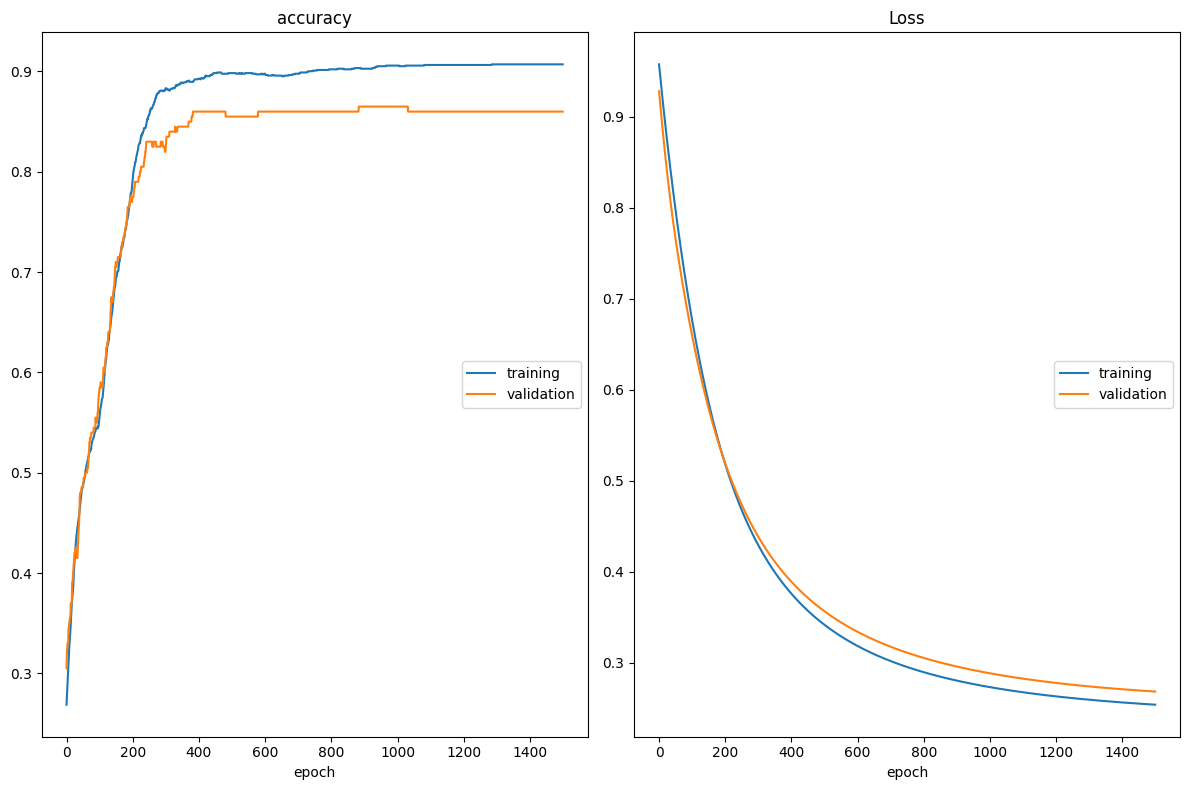

accuracy
	training         	 (min:    0.269, max:    0.907, cur:    0.907)
	validation       	 (min:    0.305, max:    0.865, cur:    0.860)
Loss
	training         	 (min:    0.254, max:    0.957, cur:    0.254)
	validation       	 (min:    0.269, max:    0.928, cur:    0.269)

Epoch 1500: saving model to /kaggle/_epoch_1500.h5
1/1 [==============================] - 1s 637ms/step - loss: 0.2541 - accuracy: 0.9071 - val_loss: 0.2685 - val_accuracy: 0.8600


In [ ]:
checkpoint = ModelCheckpoint(
    filepath='/kaggle/_epoch_{epoch:02d}.h5',
    monitor='val_loss',
    save_best_only=False,
    save_freq='epoch',
    verbose=1,
    mode = 'min' ,
    save_weights_only=False,
)
classification_model.fit(
        encoded_features_train,
        y_train,
        epochs=1500,
        batch_size=2048,
        validation_data=(encoded_features_val, y_val),
        callbacks = [PlotLossesKeras(), checkpoint]
    )


In [ ]:
encoded_features_test = encoder_model.predict(X_test, verbose=0)
predictions = classification_model.predict(encoded_features_test)
final_predictions = (predictions > 0.5).astype(int)

7/7 [==============================] - 0s 3ms/step


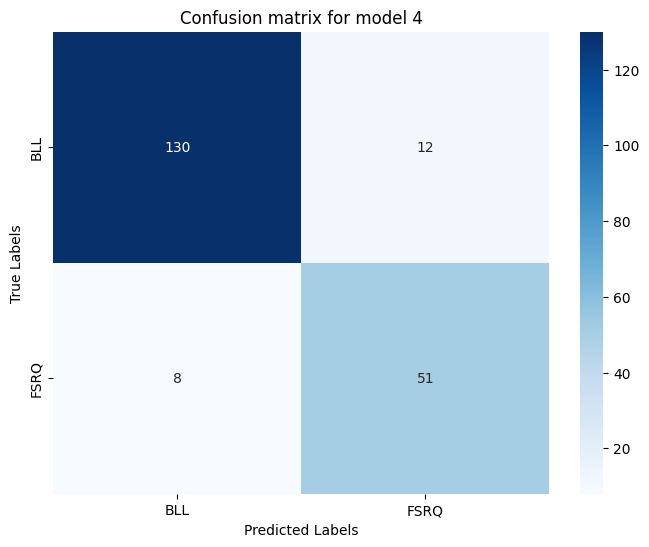

In [ ]:
conf_matrix = confusion_matrix(y_test, final_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['BLL', 'FSRQ'], yticklabels=['BLL', 'FSRQ'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion matrix for model 4')
plt.show()

# Model 5

contrastive model.avif

*In this task we will be using contrastive learning. The goal of the model is to learn similar and disimilar things. Then we will take one branch of the model use the encodings to our output layer of binary classification

In [ ]:
def create_pairs(data, labels):
    pairs, pair_labels = [], []
    num_samples = data.shape[0]
    for i in range(num_samples):
        # Use .iloc for integer-location based indexing to avoid KeyError
        positive_idx = np.where(labels == labels.iloc[i])[0]
        negative_idx = np.where(labels != labels.iloc[i])[0]

        positive_sample = data[np.random.choice(positive_idx)]
        negative_sample = data[np.random.choice(negative_idx)]

        pairs.append([data[i], positive_sample])
        pair_labels.append(1)  # Positive pair

        pairs.append([data[i], negative_sample])
        pair_labels.append(0)  # Negative pair

    return np.array(pairs), np.array(pair_labels)

In [ ]:
pairs_train, pair_labels_train = create_pairs(X_train, y_train)
pairs_val, pair_labels_val = create_pairs(X_val, y_val)

In [ ]:
input_shape = (7,)
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

shared_dense = Dense(64, activation='relu')
encoded_a = shared_dense(input_a)
encoded_b = shared_dense(input_b)

merged = Concatenate()([encoded_a, encoded_b])
output_layer = Dense(1, activation='sigmoid')(merged)

contrastive_model = Model(inputs=[input_a, input_b], outputs=output_layer)


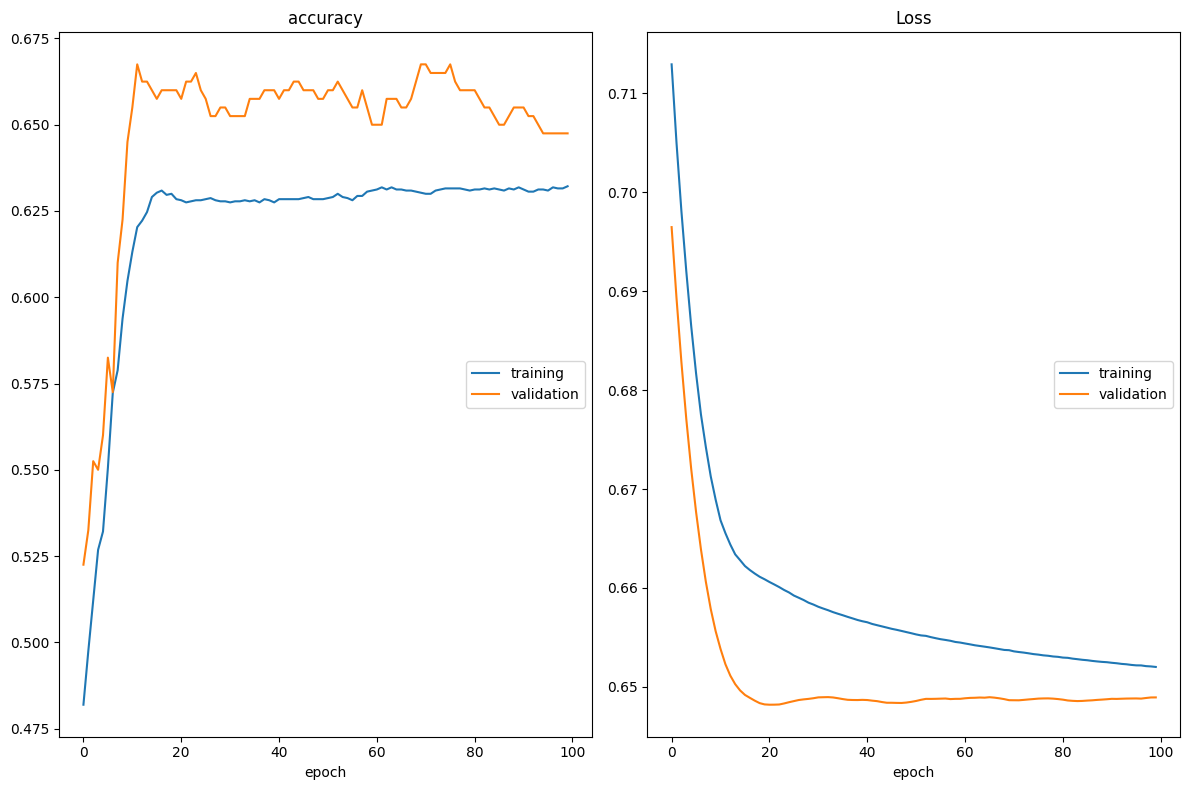

accuracy
	training         	 (min:    0.482, max:    0.632, cur:    0.632)
	validation       	 (min:    0.522, max:    0.668, cur:    0.647)
Loss
	training         	 (min:    0.652, max:    0.713, cur:    0.652)
	validation       	 (min:    0.648, max:    0.696, cur:    0.649)
2/2 [==============================] - 1s 936ms/step - loss: 0.6520 - accuracy: 0.6322 - val_loss: 0.6489 - val_accuracy: 0.6475


In [ ]:
contrastive_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
contrastive_model.fit([pairs_train[:, 0], pairs_train[:, 1]], pair_labels_train,
                      epochs=100, batch_size=2048,
                      validation_data=([pairs_val[:, 0], pairs_val[:, 1]], pair_labels_val),
                      callbacks=[PlotLossesKeras()]
                      )

In [ ]:
feature_extraction_model = Model(inputs=contrastive_model.input[0], outputs=encoded_a)
feature_extraction_model.save_weights('/content/ssl_contrastive.h5')

features_train = feature_extraction_model.predict(X_train, verbose=0)
features_val = feature_extraction_model.predict(X_val, verbose=0)
encoded_features_test = feature_extraction_model.predict(X_test, verbose=0)

In [ ]:
classification_input_layer = Input(shape=(64,))
classification_output_layer = Dense(1, activation='sigmoid')(classification_input_layer)
classification_model = Model(inputs=classification_input_layer, outputs=classification_output_layer)

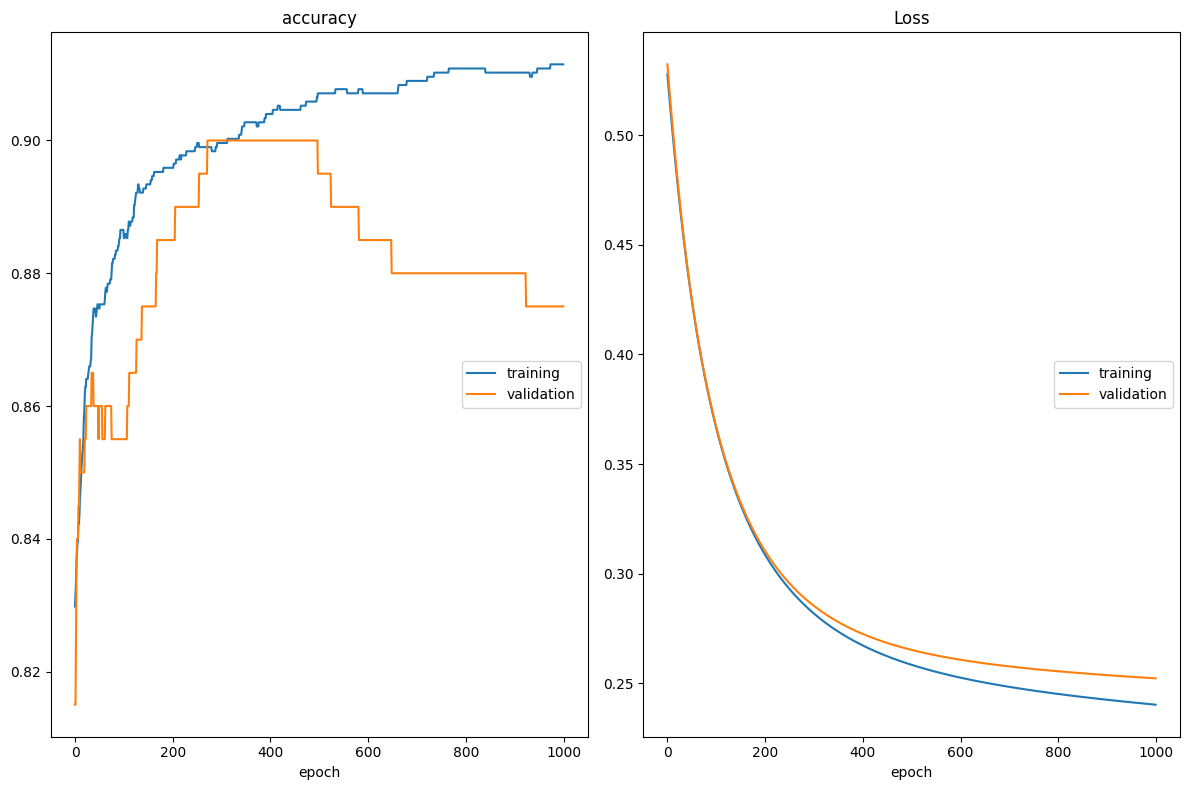

accuracy
	training         	 (min:    0.830, max:    0.911, cur:    0.911)
	validation       	 (min:    0.815, max:    0.900, cur:    0.875)
Loss
	training         	 (min:    0.240, max:    0.528, cur:    0.240)
	validation       	 (min:    0.252, max:    0.532, cur:    0.252)

Epoch 1000: saving model to /home/_epoch_1000.h5
1/1 [==============================] - 1s 632ms/step - loss: 0.2402 - accuracy: 0.9115 - val_loss: 0.2522 - val_accuracy: 0.8750


In [ ]:
classification_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint(
    filepath='/home/_epoch_{epoch:02d}.h5',
    monitor='val_loss',
    save_best_only=False,
    save_freq='epoch',
    verbose=1,
    mode = 'min' ,
    save_weights_only=False,
)
classification_model.fit(
    features_train,
    y_train,
    epochs=1000,
    batch_size=2048,
    validation_data=(features_val, y_val),
    callbacks=[PlotLossesKeras(), checkpoint])

In [ ]:
predictions = classification_model.predict(encoded_features_test)
final_predictions = (predictions > 0.5).astype(int)

7/7 [==============================] - 0s 2ms/step


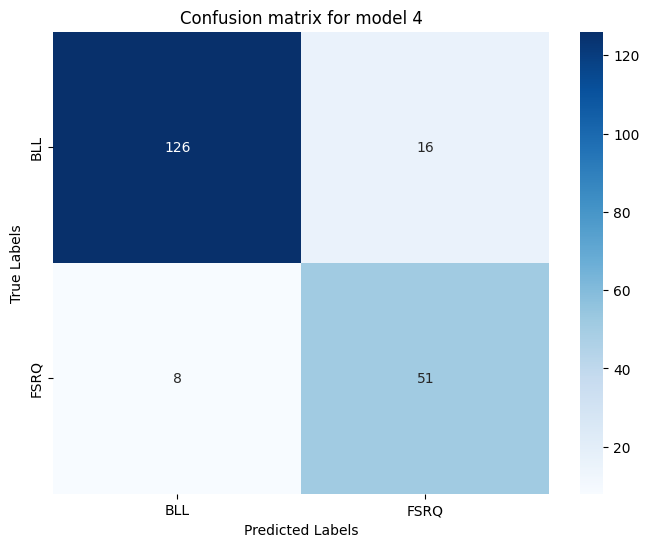

In [ ]:
conf_matrix = confusion_matrix(y_test, final_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['BLL', 'FSRQ'], yticklabels=['BLL', 'FSRQ'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion matrix for model 4')
plt.show()

# **BCU PREDICTIONS**

# Using model_1 we get BLL, FSRQ = 824, 291

In [37]:
model_epoch_40 = tf.keras.models.load_model('/_epoch_40.h5')
model_epoch_41 = tf.keras.models.load_model('/_epoch_41.h5')

pred_probs_40 = model_epoch_40.predict(bcu_samples) # Probabilities for class 1 from model at 40th epoch
pred_probs_41 = model_epoch_41.predict(bcu_samples)  # Probabilities for class 1 from model at 41st epoch

combined_pred_probs = (0.1 * pred_probs_40) + (0.9 * pred_probs_41)

final_predictions = (combined_pred_probs > 0.5).astype(int)  # Threshold at 0.5 for binary classification

bll, fsrq = np.bincount(final_predictions.flatten())
print(f"BLL: {bll}, FSRQ: {fsrq}")

35/35 [==============================] - 0s 1ms/step
BLL: 824, FSRQ: 291


# Using model_2 we get BLL, FSRQ = 766, 349

In [39]:
model_epoch_300= tf.keras.models.load_model('/_epoch_300.h5')
predictions = model_epoch_300.predict(bcu_samples)
final_predictions = (predictions > 0.5).astype(int)
bll, fsrq = np.bincount(final_predictions.flatten())
print(f"BLL: {bll}, FSRQ: {fsrq}")

35/35 [==============================] - 0s 4ms/step
BLL: 766, FSRQ: 349


# Using model_3 we get BLL, FSRQ = 749, 366

In [40]:
model_epoch_1000 = tf.keras.models.load_model('/_epoch_1000.h5')
predictions = model_epoch_1000.predict(bcu_samples)
final_predictions = (predictions > 0.5).astype(int)
bll, fsrq = np.bincount(final_predictions.flatten())
print(f"BLL: {bll}, FSRQ: {fsrq}")

35/35 [==============================] - 0s 1ms/step
BLL: 749, FSRQ: 366


# Using model_4 we get BLL, FSRQ = 740, 375

In [42]:
input_layer = Input(shape=(7,))
encoder = Dense(128, activation='relu')(input_layer)
encoder = Dense(64, activation='relu')(encoder)
encoded = Dense(32, activation='relu')(encoder)


decoder = Dense(64, activation='relu')(encoded)
decoder = Dense(128, activation='relu')(decoder)
decoded = Dense(7, activation='linear')(decoder)
encoder_model = Model(inputs=input_layer, outputs=encoded)
self_supervised_model = Model(inputs=input_layer, outputs=decoded)

In [43]:
# Load the weights
encoder_model.load_weights('/ssl_encoder.h5')

In [44]:
encoded_features_bcu = encoder_model.predict(bcu_samples)

35/35 [==============================] - 0s 1ms/step


In [45]:
classification_model = tf.keras.models.load_model('/_epoch_1500.h5')
predictions = classification_model.predict(encoded_features_bcu)
final_predictions = (predictions > 0.5).astype(int)
bll, fsrq = np.bincount(final_predictions.flatten())
print(f"BLL: {bll}, FSRQ: {fsrq}")

35/35 [==============================] - 0s 1ms/step
BLL: 740, FSRQ: 375


# Using model_5 we get BLL, FSRQ = 744, 371

In [46]:
input_shape = (7,)
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

shared_dense = Dense(64, activation='relu')
encoded_a = shared_dense(input_a)
encoded_b = shared_dense(input_b)

merged = Concatenate()([encoded_a, encoded_b])
output_layer = Dense(1, activation='sigmoid')(merged)

contrastive_model = Model(inputs=[input_a, input_b], outputs=output_layer)

In [47]:
feature_extraction_model = Model(inputs=contrastive_model.input[0], outputs=encoded_a)
feature_extraction_model.load_weights('/ssl_contrastive.h5')
features_bcu = feature_extraction_model.predict(bcu_samples, verbose=0)

In [48]:
classification_model = tf.keras.models.load_model('/_epoch_1000.h5')
predictions = classification_model.predict(features_bcu)
final_predictions = (predictions > 0.5).astype(int)
bll, fsrq = np.bincount(final_predictions.flatten())
print(f"BLL: {bll}, FSRQ: {fsrq}")

35/35 [==============================] - 0s 2ms/step
BLL: 744, FSRQ: 371
